# cluster cells based on surface markers into distrinct classes

In [1]:
from bsccm import BSCCM

dataset = BSCCM('/home/hpinkard_waller/data/BSCCM')
# dataset = BSCCM('/home/hpinkard_waller/data/BSCCM-coherent')

Opening BSCCM
Opened BSCCM


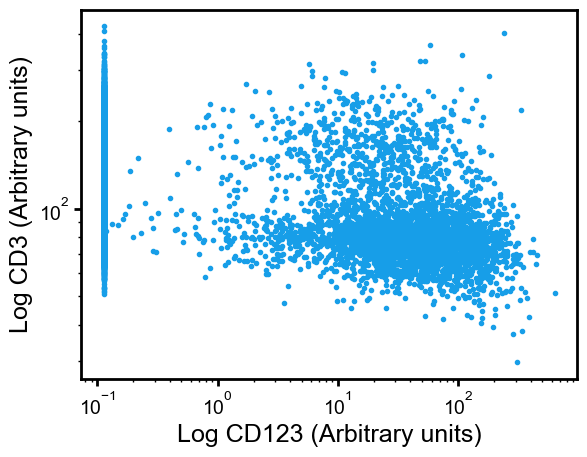

In [2]:
from cleanplots import *

# x_axis_antibody = 'CD45'
# y_axis_antibody = 'CD16'
x_axis_antibody = 'CD123'
y_axis_antibody = 'CD3'

global_indices = dataset.get_indices(batch= 1 if 'coherent' in str(dataset) else 0, antibodies='all')

two_spectra_model_names, two_spectra_data, four_spectra_model_names, four_spectra_data = \
                dataset.get_surface_marker_data(global_indices)

# figure out which column of the returned data corresponds to the antibody we're interested in
antibody_index_x = np.flatnonzero([x_axis_antibody in n for n in four_spectra_model_names])[0]
antibody_index_y = np.flatnonzero([y_axis_antibody in n for n in four_spectra_model_names])[0]

# Plot a histogram of maker expression levels
_ = plt.loglog(four_spectra_data[:, antibody_index_x], four_spectra_data[:, antibody_index_y], '.')
_ = plt.xlabel('Log ' + x_axis_antibody + ' (Arbitrary units)')
_ = plt.ylabel('Log ' + y_axis_antibody + ' (Arbitrary units)')


## Automated clustering

In [31]:
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering, MeanShift, HDBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

num_clusters = 5
seed = 1223488
seed = 5431134


# clustering = GaussianMixture(n_components=num_clusters, random_state=seed)
clustering = SpectralClustering(n_clusters=num_clusters, random_state=seed,  affinity='nearest_neighbors', assign_labels='cluster_qr')
# clustering = KMeans(n_clusters=num_clusters, random_state=seed)
# clustering = MeanShift()
# clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='average')
# clustering = HDBSCAN(cluster_selection_epsilon=0.11, min_cluster_size=200, min_samples=1)



global_indices = dataset.get_indices(batch= 1 if 'coherent' in str(dataset) else 0, antibodies='all')

two_spectra_model_names, two_spectra_data, four_spectra_model_names, four_spectra_data = \
                dataset.get_surface_marker_data(global_indices)
data = four_spectra_data

# ignore HLA-DR/CD14/CD123 channel
data = four_spectra_data[:, 1:]
four_spectra_model_names = four_spectra_model_names[1:]

log_data = np.log(data)
# nomalize each column to have mean 0 and std 1
log_data = (log_data - np.mean(log_data, axis=0)) / np.std(log_data, axis=0)


cluster_labels = clustering.fit_predict(log_data)

num_clusters = len(np.unique(cluster_labels))
if np.min(cluster_labels) == -1:
    cluster_labels += 1
print('Number of clusters: %d' % num_clusters)

Number of clusters: 5


In [18]:
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.metrics import pairwise_distances
from scipy.linalg import eigh

# Assuming you have your Nx4 matrix stored in a variable called 'data_matrix'
# Replace 'data_matrix' with your actual data

# Calculate the affinity matrix
affinity_matrix = pairwise_distances(log_data, metric='euclidean')

# Calculate the Laplacian matrix
laplacian_matrix = np.diag(np.sum(affinity_matrix, axis=1)) - affinity_matrix

# Compute the eigenvalues and eigenvectors of the Laplacian matrix
eigenvalues, eigenvectors = eigh(laplacian_matrix)

# Sort the eigenvalues in descending order
eigenvalue_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[eigenvalue_indices]

# Find the significant drop or gap in eigenvalues
eigenvalue_diffs = np.diff(sorted_eigenvalues)
num_clusters = np.argmax(eigenvalue_diffs) + 1

plt.plot(np.abs(eigenvalue_diffs[:50]), '.-')


## Load clusters from manual gating

In [21]:
marked_names = [name for name in dataset.surface_marker_dataframe.columns if 'selection_gated' in name]
cluster_indices = {}
for i, col in enumerate(marked_names):
    # Get the indices of the rows which are True for the current population
    indices = dataset.surface_marker_dataframe[dataset.surface_marker_dataframe[col]].index.tolist()

    # Store the indices in the dictionary using the population's integer key
    cluster_indices[i] = indices

global_indices = np.concatenate(list(cluster_indices.values()))
cluster_labels = np.concatenate([np.ones(len(indices)) * i for i, indices in cluster_indices.items()])

_, _, four_spectra_model_names, four_spectra_data = dataset.get_surface_marker_data(global_indices)
data = four_spectra_data

# ignore HLA-DR/CD14/CD123 channel
data = four_spectra_data[:, 1:]
four_spectra_model_names = four_spectra_model_names[1:]

log_data = np.log(data)
# nomalize each column to have mean 0 and std 1
log_data = (log_data - np.mean(log_data, axis=0)) / np.std(log_data, axis=0)



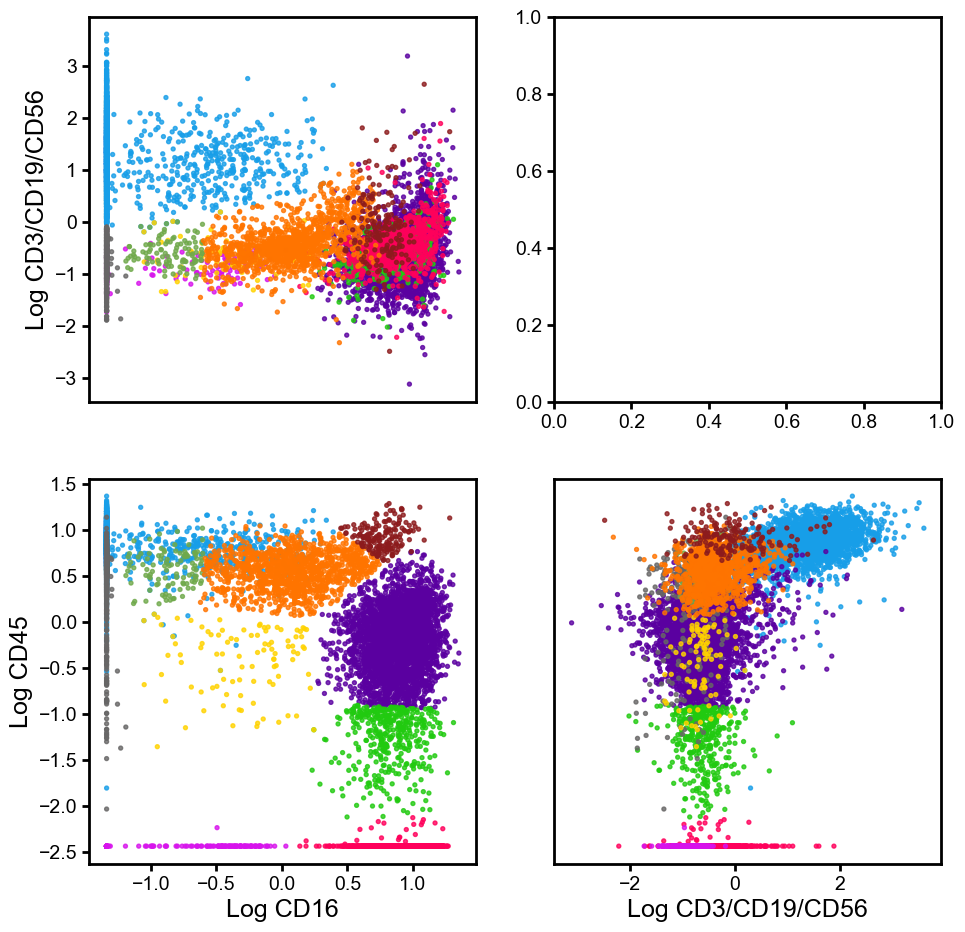

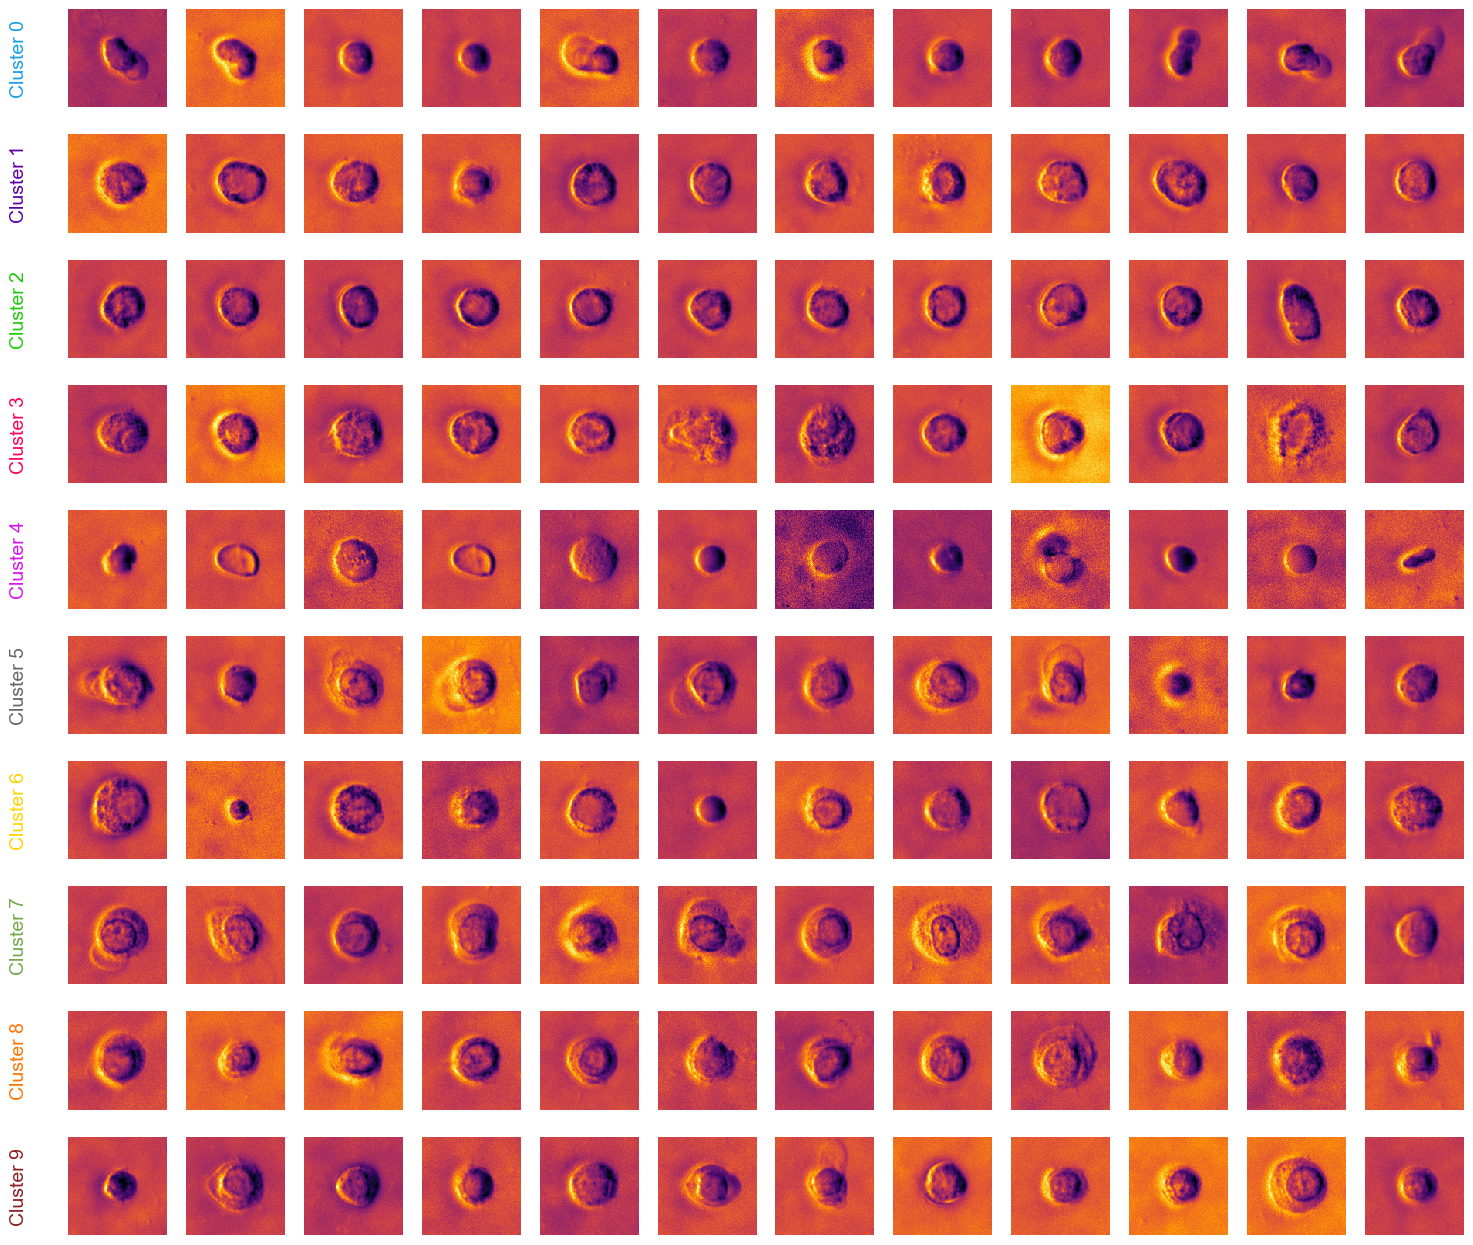

In [23]:
from bsccm.fluorescence_processing.fluor_display import load_fluor_images, make_multi_channel_fluor_images

num_to_plot = 12
show_fluor = False


num_clusters = len(np.unique(cluster_labels))
fig, axes = plt.subplots(log_data.shape[1] - 1, log_data.shape[1] - 1, figsize=(11, 11))

for i1 in range(log_data.shape[1] - 1):
    for i2 in range(i1+1):
        ax = axes[i1, i2]
        ax.scatter(log_data[:, i2 - 1], log_data[:, i1], c=cluster_labels,        
                   cmap=ListedColormap(get_color_cycle()[:num_clusters])
         , alpha=0.8, s=8, rasterized=True)
        ax.set_xlabel('Log ' + four_spectra_model_names[i2 - 1].split('_')[0] )
        ax.set_ylabel('Log ' + four_spectra_model_names[i1].split('_')[0] )
        if i2 != 0:
            ax.set(yticks=[], ylabel='')
        if i1 != axes.shape[0] - 1:
            ax.set(xticks=[], xlabel='')
        

# save figure
plt.savefig('/home/hpinkard_waller/figures/bsccm/clusters.pdf', transparent=True, dpi=300)


random_indices_by_cluster = np.stack([np.random.choice(global_indices[np.flatnonzero(cluster_labels == i)],
                             size=num_to_plot) for i in range(num_clusters)], axis=0)
if show_fluor:
    # load fluor data
    # combine all fluor images to get common contrast settings
    raw_fluor_images = load_fluor_images(dataset, random_indices_by_cluster.flatten())
    fluor_images = make_multi_channel_fluor_images(raw_fluor_images)
    # reshape by cluster index
    fluor_images = np.reshape(fluor_images, (num_clusters, num_to_plot, *fluor_images.shape[1:]))


fig, axes = plt.subplots(num_clusters, num_to_plot, figsize=(1.5 * num_to_plot, 8 / 5 * num_clusters))
for i in range(num_clusters):
    for j in range(num_to_plot):
        ax = axes[i, j]
        
        if show_fluor:
            ax.imshow(fluor_images[i, j], interpolation='nearest')
        else:
            # dpc image
            random_index = random_indices_by_cluster[i, j]
            img = dataset.read_image(random_index, channel='DPC_Right' if 'coherent' not in str(dataset) else 'dpc')
            ax.imshow(img, interpolation='nearest', cmap='inferno')

        ax.set_axis_off()
        
        if j == 0:
            # ax.set_ylabel('Cluster ' + str(i), color=get_color_cycle()[i])
            # add a label to the left of the first image
            ax.text(-0.5, 0.5, 'Cluster ' + str(i), color=get_color_cycle()[i], transform=ax.transAxes,
                    rotation=90, verticalalignment='center', horizontalalignment='center')
            
        
            
plt.savefig('/home/hpinkard_waller/figures/bsccm/cluster_sample_images.pdf', transparent=True, dpi=300)



In [16]:
Lymphocytes: 0
Monocytes: 7 8 9
Granulocytes: 1 2 3
RBCs: 4
Unknown: 5 6 